# National Park Analysis

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
from datetime import datetime
import time
import urllib.request
import json
from pathlib import Path

# Import the NPS API key
from api_key import nps_key

# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/campgrounds"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10)
print(f"Status: {res.status}")

Status: 200


### Get National Park Dictionary

- This is to translate the 4-letter park code to the park name

In [2]:
park_dict_path = Path("output_data/park_dict_df.csv")
park_dict_df = pd.read_csv(park_dict_path)
park_dict_df = park_dict_df.set_index("Park Code")
code_to_name = park_dict_df.to_dict()

## Section 1 -  Campgrounds With Tent Only And RV Only Sites In Each National Park

##### NOTE : Base URL: developer.nps.gov/api/v1


In [3]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/campgrounds?limit=650"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10).read()
json_camps = json.loads(res.decode("utf-8"))

In [4]:
# Creating lists
campgrounds = []
parkCode = []
totalsites = []
tentonly = []
electricalhookups = []
Park_Name = []

# For loop
for camp in json_camps["data"]:
    campgrounds.append(camp['name'])
    parkCode.append(camp['parkCode'])
    totalsites.append(camp['campsites']['totalSites'])
    tentonly.append(camp['campsites']['tentOnly'])
    electricalhookups.append(camp['campsites']['electricalHookups'])
    
for park in parkCode:
    try:
        Park_Name.append(code_to_name['Full Name'][park])
    except:
        Park_Name.append("N/A")
    
# Create a dataframe with these lists
camps_df = pd.DataFrame({"Camp Name": campgrounds,
                         "Park Name": Park_Name,
                         "Park Code": parkCode, 
                         "total Campsites": totalsites, 
                         "tent only sites": tentonly, 
                         "electrical hookups (for RV)": electricalhookups})

# Display the dataframe
camps_df

,Camp Name,Park Name,Park Code,total Campsites,tent only sites,electrical hookups (for RV)
0,277 North Campground,Amistad,amis,18,0,0
1,Abrams Creek Campground,Great Smoky Mountains,grsm,16,0,0
2,Adirondack Shelters,Catoctin Mountain,cato,2,0,0
3,Afterbay Campground,Bighorn Canyon,bica,22,0,22
4,Akers Group Campground,Ozark National Scenic Riverway,ozar,4,4,0
...,...,...,...,...,...,...
629,Wonder Lake,Denali,dena,28,28,0
630,Wood Lake Campground,Isle Royale,isro,3,3,0
631,Woolum,Buffalo,buff,0,0,0
632,Yankee Paradise Wilderness Campsite,Cumberland Island,cuis,4,4,0


In [5]:
# Export the camp data into a csv
camps_df.to_csv("output_data/camps.csv", index_label="Camp Name")

### Graph 1 - Visualizing The Data Frame For National Parks With The Most Campgrounds

Park Code
acad     4
amis     5
amme     1
arch     1
asis    11
        ..
wica     1
wrst     1
yell    12
yose    14
zion     3
Name: Camp Name, Length: 117, dtype: int64


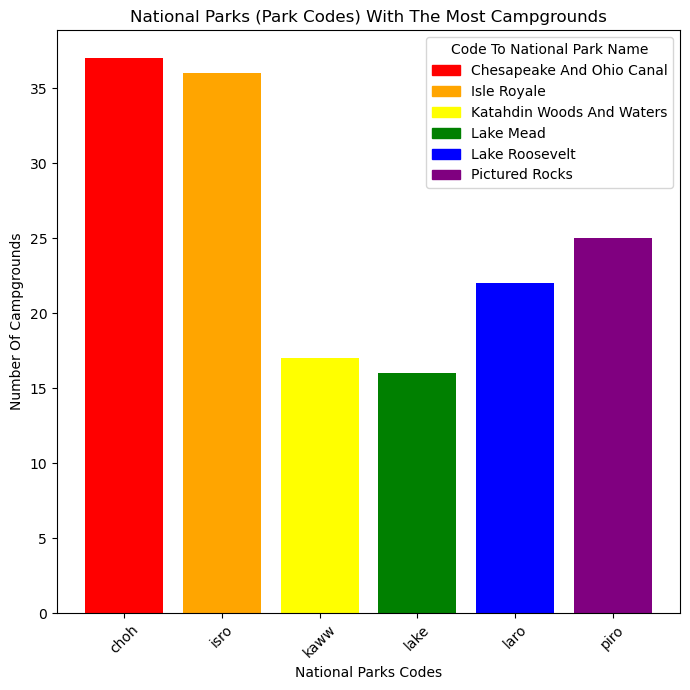

In [6]:
# Setting variables
camps_by_park = camps_df.groupby("Park Code")['Camp Name'].count()
most_camps = camps_by_park.loc[(camps_by_park.values > 14)]
print(camps_by_park)

#getting the labels for the legend
most_camps_labels = []
for name in range(0, most_camps.size):
    most_camps_labels.append(code_to_name['Full Name'][most_camps.index[name]])
colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Creating bar graph
plt.figure(figsize=(7, 7))
plt.bar(most_camps.index, most_camps.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, most_camps.size)]

# Setting title and labels for bar graph
plt.title("National Parks (Park Codes) With The Most Campgrounds")
plt.legend(handles, most_camps_labels, title="Code To National Park Name")
plt.xlabel("National Parks Codes")
plt.ylabel("Number Of Campgrounds")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-1.png")
plt.tight_layout()
plt.show()

### Graph 2 - Visualizing the Data Frame For Percentage Of Campsite Types (RV or Tent Only Sites) In All National Parks

                             Campsites Type
Tent Only Sites                        6766
Electrical Hookups (for RV)            2664


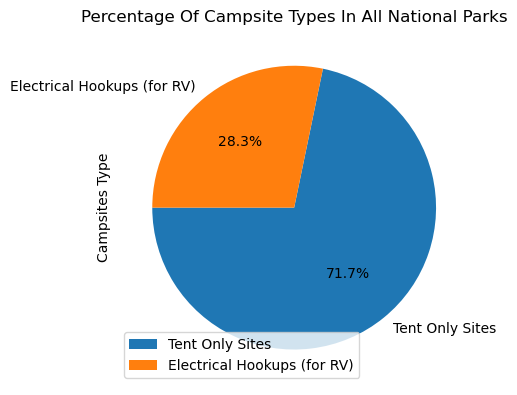

In [7]:
# Setting variables
camps_df['total Campsites'] = camps_df['total Campsites'].astype(int)
camps_df['tent only sites'] = camps_df['tent only sites'].astype(int)
camps_df['electrical hookups (for RV)'] = camps_df['electrical hookups (for RV)'].astype(int)
campsites_by_park = camps_df.groupby(by="Park Code")['total Campsites'].sum()
tentOnly_by_park = camps_df.groupby(by="Park Code")['tent only sites'].sum()
RVspots_by_park = camps_df.groupby(by="Park Code")['electrical hookups (for RV)'].sum()
campsites_type = [tentOnly_by_park.sum(), RVspots_by_park.sum()]
campsites_sorted = pd.DataFrame(campsites_type, 
                                index = ['Tent Only Sites', 'Electrical Hookups (for RV)'], 
                                columns=['Campsites Type'])
print(campsites_sorted)
#print(RVspots_by_park.sum())
# Creating pie graph
campsites_sorted.plot.pie(y='Campsites Type', 
                          autopct='%1.1f%%', 
                          startangle=180, 
                          figsize=(5, 5), 
                          title="Percentage Of Campsite Types In All National Parks")

# Display and save pie graph
plt.savefig("output_data/Images/piegraph-1.png")
plt.tight_layout()
plt.show()

### Graph 3 - Visualizing The Data Frame For The Top 6 National Parks With The Most Tent Only Campsites

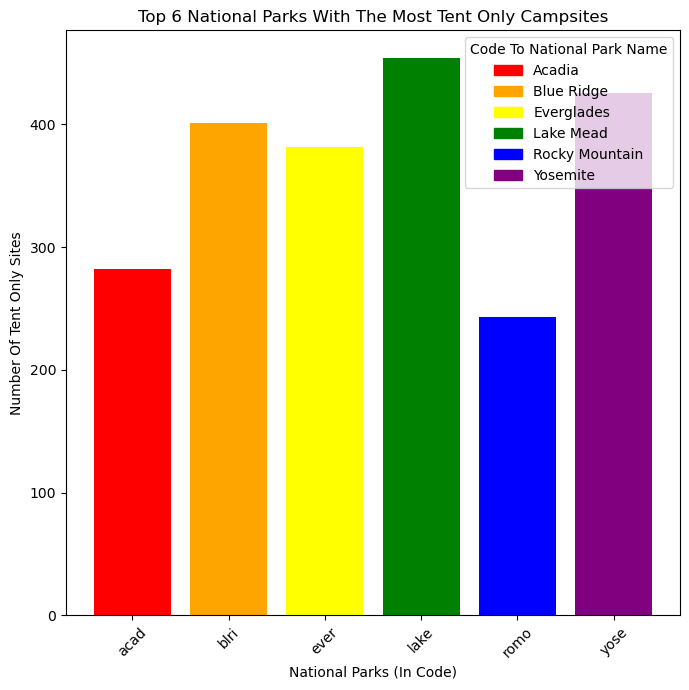

In [8]:
most_tents = tentOnly_by_park.loc[(tentOnly_by_park.values > 199)]

#getting the labels for the legend
tent_parks_labels = []
for name in range(0, most_tents.size):
    tent_parks_labels.append(code_to_name['Full Name'][most_tents.index[name]])
colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Creating bar graph
plt.figure(figsize=(7, 7))
plt.bar(most_tents.index, most_tents.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, most_tents.size)]

# Setting title and labels for bar graph
plt.title("Top 6 National Parks With The Most Tent Only Campsites")
plt.legend(handles, tent_parks_labels, title="Code To National Park Name")
plt.xlabel("National Parks (In Code)")
plt.ylabel("Number Of Tent Only Sites")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-2.png")
plt.tight_layout()
plt.show()

### Graph 4 - Visualizing The Data Frame For The Top 6 National Parks With The Most Electrical Hookups For RV) Campsites

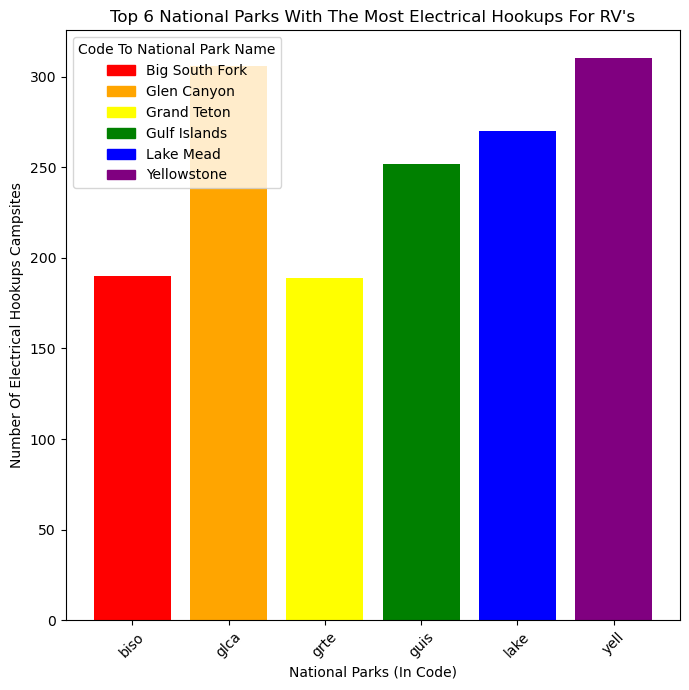

In [9]:
most_Electrical = RVspots_by_park.loc[(RVspots_by_park.values > 150)]

#getting the labels for the legend
RV_parks_labels = []
for name in range(0, most_Electrical.size):
    RV_parks_labels.append(code_to_name['Full Name'][most_Electrical.index[name]])
colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Creating bar graph
plt.figure(figsize=(7, 7))
plt.bar(most_Electrical.index, most_Electrical.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, most_Electrical.size)]

# Setting title and labels for bar graph
plt.title("Top 6 National Parks With The Most Electrical Hookups For RV's")
plt.legend(handles, RV_parks_labels, title="Code To National Park Name")
plt.xlabel("National Parks (In Code)")
plt.ylabel("Number Of Electrical Hookups Campsites")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-3.png")
plt.tight_layout()
plt.show()

In [10]:
print(f"{code_to_name['Full Name'][camps_by_park.idxmax()]} has the most ({camps_by_park.max()}) campgrounds.")
print(f"There are {camps_by_park.size} national parks that have the least campgrounds.")

Chesapeake And Ohio Canal has the most (37) campgrounds.
There are 117 national parks that have the least campgrounds.


### Summary Statistics 1 - Campgrounds and National Parks

In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM For Campgrounds and National Parks
df_mean = camps_df['total Campsites'].astype(int).mean(axis=0)
df_median = camps_df['total Campsites'].astype(int).median(axis=0)
df_variance = camps_df['total Campsites'].astype(int).var(axis=0)
df_stdv = camps_df['total Campsites'].astype(int).std(axis=0)
df_sem = camps_df['total Campsites'].astype(int).sem(axis=0)

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
df_summary_camps = pd.DataFrame({"Mean Campsites": df_mean,
                                    "Median Campsites": df_median,
                                    "Campsites Variance": df_variance,
                                    "Campsites Std. Dev.": df_stdv,
                                    "Campsites Std. Err.": df_sem},
                                    index=[0])
df_summary_camps

,Mean Campsites,Median Campsites,Campsites Variance,Campsites Std. Dev.,Campsites Std. Err.
0,50.547319,15.0,42791.350838,206.860704,8.215488


### Analysis and Conclusions 1 - Explanation Of Visualizations For Campgrounds With Tent Only And RV Only Sites In Each National Park

- Graph 1 shows us the national parks with the most campgrounds (both tent only and rv only). It tells us Chesapeake And Ohio Canal National Park has the most campgrounds at 37. Lake Mead had the least amount of campgrounds with 15 sites in park. To make it easy for the tourist to prioritize camping we excluded national parks with less than 15 campsites. (A total of 117 had at least 1 but less than 15).

- Graph 2 shows us the percentage of campsite types (tent only and rv only) for all national parks. Tent sites make up 71.7% of all sites across all national parks while RV sites with electrical hookups make up only 28.3%

- Graph 3 shows us the top 6 national parks that only have tent campsites. This could be useful information for travelers who are looking for the best parks to pitch a tent at based on the total number of available tent sites. For example, in this case Lake Mead National Park has the most tent only campsites with more than 400 sites. Rocky Mountain National Park came in with least amount of options with approximately 250 sites.

- Graph 4 shows us the top 6 national parks that only have rv campsites. This could be useful information for travelers who are looking for the best parks to hook up their rv based on the total number of available rv sites. For example, in this case Yellostone National Park has the most campsites with electrical hookups for RV's with more than 300 and Glen Canyon in a close second. Big South Fork and Grand Teton tied for the lowest with approximately 190.

## Section 2 - National Parks With The Most Amenities (In The Campgrounds)

In [12]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/campgrounds?limit=650"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10).read()
json_camps = json.loads(res.decode("utf-8"))

In [13]:
# Creating lists
campgrounds = []
parkCode = []
amenities = []
Park_Name = []

# For loop
for camp in json_camps["data"]:
    campgrounds.append(camp['name'])
    parkCode.append(camp['parkCode'])
    amenities.append(camp['amenities'])
    
for park in parkCode:
    try:
        Park_Name.append(code_to_name['Full Name'][park])
    except:
        Park_Name.append("N/A")
    
# Create a dataframe with these lists
amenities_df = pd.DataFrame({"Camp Name": campgrounds,
                             "Park Name": Park_Name,
                             "Park Code": parkCode, 
                             "Amenities": amenities})

# Display the dataframe
amenities_df

,Camp Name,Park Name,Park Code,Amenities
0,277 North Campground,Amistad,amis,{'trashRecyclingCollection': 'Yes - year round...
1,Abrams Creek Campground,Great Smoky Mountains,grsm,"{'trashRecyclingCollection': 'Yes - seasonal',..."
2,Adirondack Shelters,Catoctin Mountain,cato,"{'trashRecyclingCollection': 'No', 'toilets': ..."
3,Afterbay Campground,Bighorn Canyon,bica,"{'trashRecyclingCollection': 'Yes - seasonal',..."
4,Akers Group Campground,Ozark National Scenic Riverway,ozar,"{'trashRecyclingCollection': 'Yes - seasonal',..."
...,...,...,...,...
629,Wonder Lake,Denali,dena,"{'trashRecyclingCollection': 'Yes - seasonal',..."
630,Wood Lake Campground,Isle Royale,isro,"{'trashRecyclingCollection': 'No', 'toilets': ..."
631,Woolum,Buffalo,buff,"{'trashRecyclingCollection': 'No', 'toilets': ..."
632,Yankee Paradise Wilderness Campsite,Cumberland Island,cuis,"{'trashRecyclingCollection': 'No', 'toilets': ..."


In [14]:
#Organize the data frame a bit more...
amenities_detail = []
for row in range(0, 634):
    a = amenities_df.iloc[row,3]
    amenities_detail.append(a)

amenities_detail_df = pd.DataFrame.from_dict(amenities_detail)
amenities_detail_df.insert(0, 'Camp Name', campgrounds)
amenities_detail_df.insert(1, 'Park Name', Park_Name)
amenities_detail_df.insert(2, 'Park Code', parkCode)
amenities_detail_df.head()

,Camp Name,Park Name,Park Code,trashRecyclingCollection,toilets,internetConnectivity,showers,cellPhoneReception,laundry,amphitheater,dumpStation,campStore,staffOrVolunteerHostOnsite,potableWater,iceAvailableForSale,firewoodForSale,foodStorageLockers
0,277 North Campground,Amistad,amis,Yes - year round,[Vault Toilets - year round],No,[None],Yes - year round,No,No,No,No,No,[No water],No,No,No
1,Abrams Creek Campground,Great Smoky Mountains,grsm,Yes - seasonal,[Vault Toilets - seasonal],No,[None],No,No,No,No,No,Yes - seasonal,[Yes - seasonal],No,No,Yes - seasonal
2,Adirondack Shelters,Catoctin Mountain,cato,No,[Vault Toilets - year round],No,[None],No,No,No,No,No,No,[No water],No,No,No
3,Afterbay Campground,Bighorn Canyon,bica,Yes - seasonal,[Composting Toilets - year round],No,[None],No,No,Yes - seasonal,Yes - seasonal,No,Yes - seasonal,[Yes - seasonal],No,No,Yes - year round
4,Akers Group Campground,Ozark National Scenic Riverway,ozar,Yes - seasonal,[Vault Toilets - seasonal],No,[None],No,No,No,No,Yes - seasonal,No,[Yes - seasonal],Yes - seasonal,Yes - seasonal,No


In [15]:
#get the total amenities in dataframe
amenities_count = []
count = 0

for row in range(0, 634):
    a_str = str(amenities_df.iloc[row,3])
    count = a_str.count('No')
    amenities_count.append((14-count)) #needed to included toilets

amenities_detail_df.insert(3, 'Amenities Count', amenities_count)
amenities_detail_df.head()

,Camp Name,Park Name,Park Code,Amenities Count,trashRecyclingCollection,toilets,internetConnectivity,showers,cellPhoneReception,laundry,amphitheater,dumpStation,campStore,staffOrVolunteerHostOnsite,potableWater,iceAvailableForSale,firewoodForSale,foodStorageLockers
0,277 North Campground,Amistad,amis,3,Yes - year round,[Vault Toilets - year round],No,[None],Yes - year round,No,No,No,No,No,[No water],No,No,No
1,Abrams Creek Campground,Great Smoky Mountains,grsm,5,Yes - seasonal,[Vault Toilets - seasonal],No,[None],No,No,No,No,No,Yes - seasonal,[Yes - seasonal],No,No,Yes - seasonal
2,Adirondack Shelters,Catoctin Mountain,cato,1,No,[Vault Toilets - year round],No,[None],No,No,No,No,No,No,[No water],No,No,No
3,Afterbay Campground,Bighorn Canyon,bica,7,Yes - seasonal,[Composting Toilets - year round],No,[None],No,No,Yes - seasonal,Yes - seasonal,No,Yes - seasonal,[Yes - seasonal],No,No,Yes - year round
4,Akers Group Campground,Ozark National Scenic Riverway,ozar,6,Yes - seasonal,[Vault Toilets - seasonal],No,[None],No,No,No,No,Yes - seasonal,No,[Yes - seasonal],Yes - seasonal,Yes - seasonal,No


In [16]:
# Export the amenities data into a csv
amenities_df.to_csv("output_data/amenities.csv", index_label="Camp Name")

### Graph 5 - Visualizing The Data Frame For The National Parks With The Most Amenities By Average

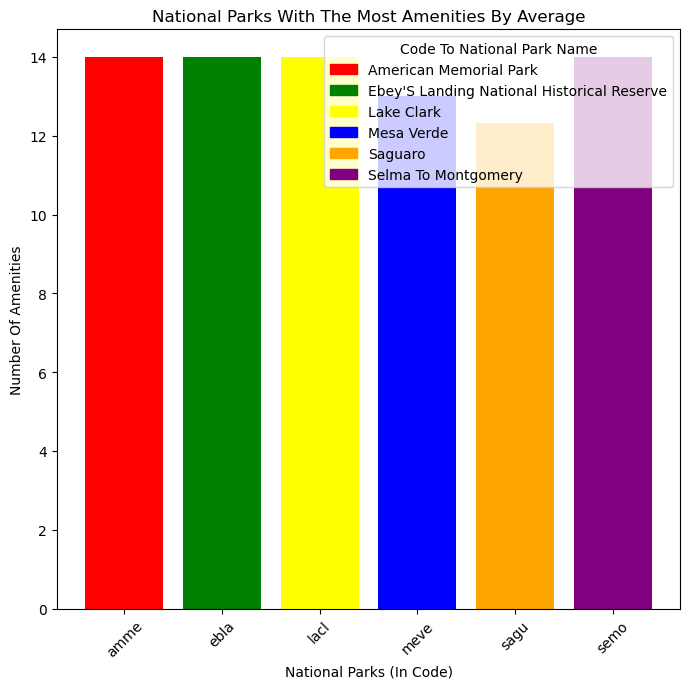

In [17]:
# Setting variables
total_amentities_by_park = amenities_detail_df.groupby("Park Code")['Amenities Count'].mean()
most_amentities = total_amentities_by_park.loc[(total_amentities_by_park.values > 12)]
#print(total_amentities_by_park)

#getting the labels for the legend
most_amen_labels = []
for name in range(0, most_amentities.size):
    most_amen_labels.append(code_to_name['Full Name'][most_amentities.index[name]])
colors=['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'cyan', 
        'pink', 'cornflowerblue', 'salmon', 'lightgreen', 'crimson', 'tan']


# Creating bar graph
plt.figure(figsize=(7, 7))
plt.bar(most_amentities.index, most_amentities.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, most_amentities.size)]

# Setting title and labels for bar graph
plt.title("National Parks With The Most Amenities By Average")
plt.legend(handles, most_amen_labels, title="Code To National Park Name")
plt.xlabel("National Parks (In Code)")
plt.ylabel("Number Of Amenities")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-4.png")
plt.tight_layout()
plt.show()

### Graph 6 - Visualizing The Data Frame For The Percentages Of Each Amenity In All US National Parks

Percentages of Each Amenity in National Parks
trashRecyclingCollection      66.561514
toilets                           100.0
internetConnectivity            9.77918
showers                           100.0
cellPhoneReception            38.170347
laundry                       10.567823
amphitheater                  33.911672
dumpStation                   32.334385
campStore                     19.242902
staffOrVolunteerHostOnsite    49.842271
potableWater                      100.0
iceAvailableForSale           19.400631
firewoodForSale               22.712934
foodStorageLockers            38.801262
dtype: object


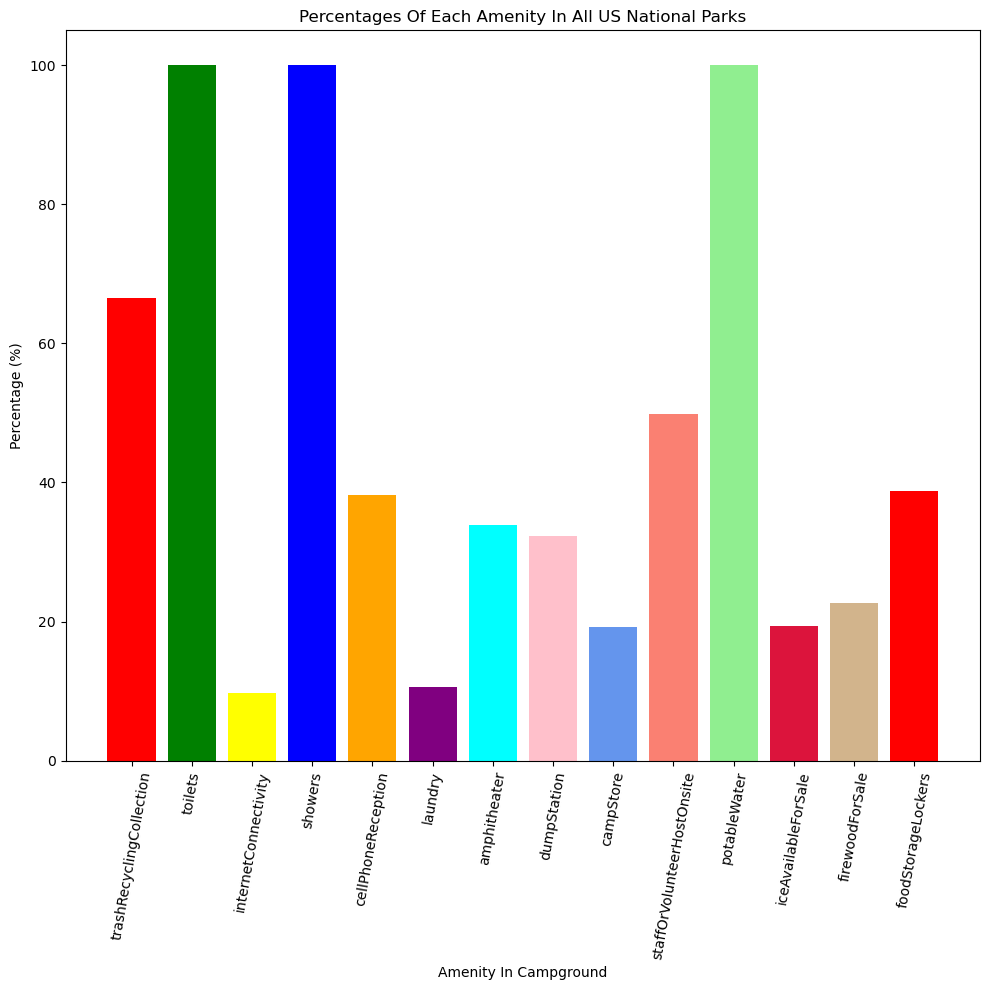

In [18]:
# Setting variables
amenities_type_binary = amenities_detail_df.iloc[:,4:]
columns = amenities_type_binary.columns
for col in columns:
    amenities_type_binary.loc[amenities_type_binary[col] == "No", col] = 0
    amenities_type_binary.loc[~(amenities_type_binary[col] == 0), col] = 1
amenities_type_sum = amenities_type_binary.sum()

#get the percentages
amenities_type_sum = (amenities_type_sum/634)*100.0 #634 total campsites
print("Percentages of Each Amenity in National Parks")
print(amenities_type_sum)

# Creating pie graph
plt.figure(figsize=(10, 10))
plt.title("Percentages Of Each Amenity In All US National Parks")
plt.xlabel("Amenity In Campground")
plt.ylabel("Percentage (%)")
plt.bar(amenities_type_sum.index, amenities_type_sum.values, color=colors)
plt.xticks(rotation = 80)

# Display and save pie graph
plt.savefig("output_data/Images/bargraph-5.png")
plt.tight_layout()
plt.show()

In [19]:
print(f"There are {most_amentities.size} parks with at least 2 amenities.")
print(f"{code_to_name['Full Name'][most_amentities.idxmax()]} National Park has the most ({most_amentities.max()}) amenities.")

There are 6 parks with at least 2 amenities.
American Memorial Park National Park has the most (14.0) amenities.


### Summary Statistics 2 -  Amenities And National Parks

In [20]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM For Amenities and National Parks
df_mean = amenities_detail_df['Amenities Count'].astype(int).mean(axis=0)
df_median = amenities_detail_df['Amenities Count'].astype(int).median(axis=0)
df_variance = amenities_detail_df['Amenities Count'].astype(int).var(axis=0)
df_stdv = amenities_detail_df['Amenities Count'].astype(int).std(axis=0)
df_sem = amenities_detail_df['Amenities Count'].astype(int).sem(axis=0)

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
df_summary_amenities = pd.DataFrame({"Mean Amenities": df_mean,
                                    "Median Amenities": df_median,
                                    "Amenities Variance": df_variance,
                                    "Amenities Std. Dev.": df_stdv,
                                    "Amenities Std. Err.": df_sem},
                                    index=[0])
df_summary_amenities

,Mean Amenities,Median Amenities,Amenities Variance,Amenities Std. Dev.,Amenities Std. Err.
0,5.291798,4.0,13.347579,3.653434,0.145096


### Analysis and Conclusions 2 - Explanation Of Visualizations For National Parks With The Most Amenities (In The Campgrounds)

- Graph 5 shows us the average number of amenities in the campgrounds per national park. This information could be useful to travelers who want to go to a park with the most number of amenities on average. The national parks which had the most amenities on average were American Memorial Park, Ebey’s Landing National Historical Reserve, Selma to Montgomery National Park and Lake Clark National Park with 14 total amenities each. The runner up was Mesa Verde National Park with 13 amenities

- Graph 6 shows us the percentages of each amenity in all US national parks. This information could be useful for travelers who want to know what sort of amenities they can expect at any given national park. For instance in this case 100% of national parks have toilets, showers and potable water. We suppose there are federal laws for this. The least common amenity is internet connectivity at 9.8%. The runner up for the least common amenity is laundry at 10.7%. Approximately 66% of campgrounds have trash/recycling collection.

## Section 3 - National Parks With The Most Activities

In [21]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/activities/parks"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10)
print(f"Status: {res.status}")

Status: 200


In [22]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/activities/parks?limit=650"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10).read()
json_activities = json.loads(res.decode("utf-8"))

In [23]:
# Creating lists
activities = []
parkCode = []
Park_Name = []

# For loop
for activity in json_activities["data"]:
    activities.append(activity['name'])
    parkCode.append(activity['parks'][0]['parkCode'])
    Park_Name.append(activity['parks'][0]['fullName'])
    
# Create a dataframe with these lists
activities_df = pd.DataFrame({"Activity": activities,
                             "Park Name": Park_Name, 
                             "Park Code": parkCode})

# Display the dataframe
activities_df

,Activity,Park Name,Park Code
0,Arts and Culture,Acadia National Park,acad
1,Astronomy,Abraham Lincoln Birthplace National Historical...,abli
2,Auto and ATV,Ala Kahakai National Historic Trail,alka
3,Biking,Acadia National Park,acad
4,Boating,Acadia National Park,acad
5,Camping,Acadia National Park,acad
6,Canyoneering,Arches National Park,arch
7,Caving,Buffalo National River,buff
8,Climbing,Acadia National Park,acad
9,Compass and GPS,Acadia National Park,acad


In [24]:
# Export the activities data into a csv
activities_df.to_csv("output_data/activities_df.csv", index_label="Activity")

### Graph 7 - Visualizing The Data Frame For The National Parks With The Most Activities

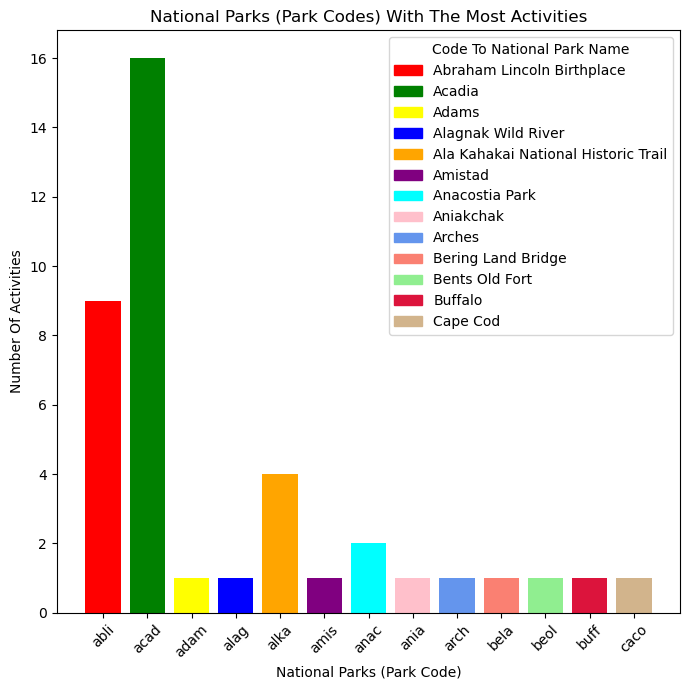

In [25]:
# Setting variables
total_activity_by_park = activities_df.groupby("Park Code")['Activity'].count()
most_activities = total_activity_by_park.loc[(total_activity_by_park.values > 0)]
#print(total_activity_by_park)

#getting the labels for the legend
most_act_labels = []
for name in range(0, most_activities.size):
    most_act_labels.append(code_to_name['Full Name'][most_activities.index[name]])
colors=['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'cyan', 
        'pink', 'cornflowerblue', 'salmon', 'lightgreen', 'crimson', 'tan']

# Creating bar graph
plt.figure(figsize=(7, 7))
plt.bar(most_activities.index, most_activities.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, most_activities.size)]

# Setting title and labels for bar graph
plt.title("National Parks (Park Codes) With The Most Activities")
plt.legend(handles, most_act_labels, title="Code To National Park Name")
plt.xlabel("National Parks (Park Code)")
plt.ylabel("Number Of Activities")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-6.png")
plt.tight_layout()
plt.show()

### Graph 8 - Visualizing The Data Frame For The Percentage Of National Parks With At Least 1 Activity

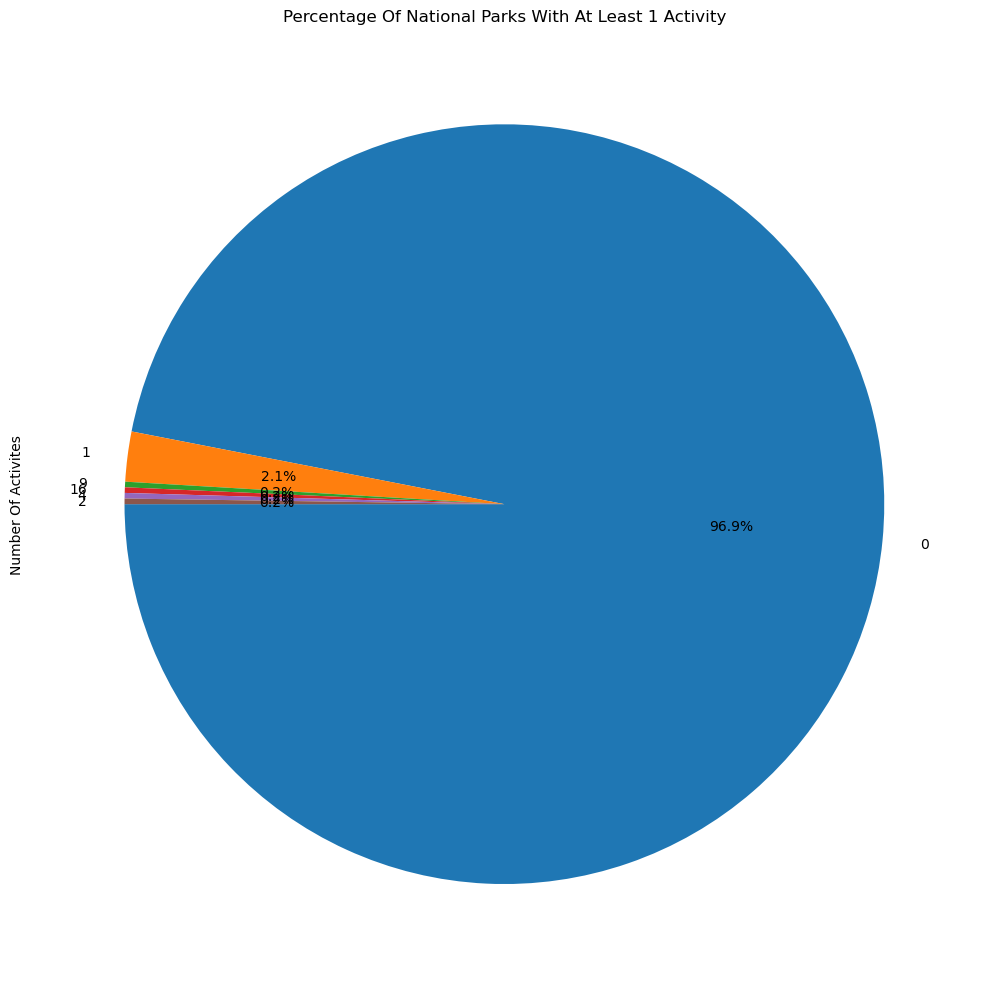

In [26]:
# Setting variables
np_number_act = total_activity_by_park.value_counts()
np_number_act_total = np_number_act.sum()

zero_act = pd.Series([424-np_number_act_total], index=[0])
np_number_act = pd.concat([zero_act,np_number_act.loc[:]])

#creating the pie graph
plt.figure(figsize=(10, 10))
plt.pie(np_number_act, labels=np_number_act.index, autopct='%1.1f%%', startangle=180)

# Setting title and labels for bar graph
plt.title("Percentage Of National Parks With At Least 1 Activity")
plt.ylabel("Number Of Activites")

# Display and save bar graph
plt.savefig("output_data/Images/piegraph-2.png")
plt.tight_layout()
plt.show()

In [27]:
print(f"There are {most_activities.size} parks with at least 2 activities.")
print(f"{code_to_name['Full Name'][most_activities.idxmax()]} National Park has the most ({most_activities.max()}) activities.")

There are 13 parks with at least 2 activities.
Acadia National Park has the most (16) activities.


### Summary Statistics 3 - Activities and National Parks

In [28]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM For Activities and National Parks
df_mean = total_activity_by_park.values.mean(axis=0)
df_median = total_activity_by_park.median(axis=0)
df_variance = total_activity_by_park.values.var(axis=0)
df_stdv = total_activity_by_park.values.std(axis=0)
df_sem = total_activity_by_park.sem(axis=0)

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
df_summary_activities = pd.DataFrame({"Mean Activities": df_mean,
                                    "Median Activities": df_median,
                                    "Activities Variance": df_variance,
                                    "Activities Std. Dev.": df_stdv,
                                    "Activities Std. Err.": df_sem},
                                    index=[0])
df_summary_activities

,Mean Activities,Median Activities,Activities Variance,Activities Std. Dev.,Activities Std. Err.
0,3.076923,1.0,18.686391,4.322776,1.247878


### Analysis and Conclusions 3 - Explanation Of Visualization For National Parks With The Most Activities

- Graph 7 shows us the total number of activities for the parks that have the most activities. This information could be useful to traverlers who want to go to a park with the most number of activities to participate in. For example, in this case Acadia National Park has the most number of activities to participate in at 16. The runner-up is Abraham Lincoln Birthplace Historical Park with 9 total activities.

- Graph 8 shows us the percentage of national parks with at least 1 activity. This information tells us activies are uncommon at national parks with 96.9% of the national parks have zero activities.  3.1% (40 parks) national parks have at least 1 activity.

## Section 4 - National Parks With The Most Events

In [29]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/events"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10)
print(f"Status: {res.status}")

Status: 200


In [30]:
# Configure NPS API request
endpoint = "https://developer.nps.gov/api/v1/events?limit=650"
HEADERS = {"X-Api-Key":nps_key}
req = urllib.request.Request(endpoint,headers=HEADERS)
res = urllib.request.urlopen(req, timeout=10).read()
json_events = json.loads(res.decode("utf-8"))

In [31]:
# Creating lists
events = []
sitecode = []
Park_Name = []
event_type = []
event_cat = []

# For loop
for event in json_events["data"]:
    events.append(event['title'])
    sitecode.append(event['sitecode'])
    Park_Name.append(event['parkfullname'])
    event_type.append('/'.join(event['types']))
    event_cat.append(event['category'])    

# Create a dataframe with these lists
events_df = pd.DataFrame({"Event": events,
                          "Park Name": Park_Name, 
                          "Park Code": sitecode, 
                          "Type" : event_type, 
                          "Category": event_cat})

# Display the dataframe
events_df

,Event,Park Name,Park Code,Type,Category
0,Decoration Day Cemetery Quest,Big South Fork National River & Recreation Area,biso,Other,Special Event
1,Charcoal Burn,Hopewell Furnace National Historic Site,hofu,Cultural/Craft Demonstration,Special Event
2,"""Minute Memoirs"" Writing Workshop",Catoctin Mountain Park,cato,Cultural/Craft Demonstration,Regular Event
3,20 minute Ranger-Led Program (Yorktown),Yorktown Battlefield Part of Colonial National...,york,Guided Tour/Talk,Regular Event
4,45 minute Ranger-Led Program (Yorktown),Yorktown Battlefield Part of Colonial National...,york,Guided Tour/Talk/Walk,Regular Event
5,8 am to 7 pm - Village: History Exhibit: The A...,Grand Canyon National Park,grca,Exhibition/Show,Regular Event
6,Acadian Cultural Center Louisiana Talks & Tales,Jean Lafitte National Historical Park and Pres...,jela,Talk,Regular Event
7,Adopt-a-Trail,Cuyahoga Valley National Park,cuva,Volunteer Event,Regular Event
8,Anhinga Amble (Royal Palm),Everglades National Park,ever,Walk,Regular Event
9,Archeology Talk,Capitol Reef National Park,care,Talk,Regular Event


In [32]:
# Export the events data into a csv
events_df.to_csv("output_data/events.csv", index_label="Event")

### Graph 9 - Visualizing The Data Frame For The Total Number Of Events In National Parks With The Most Events

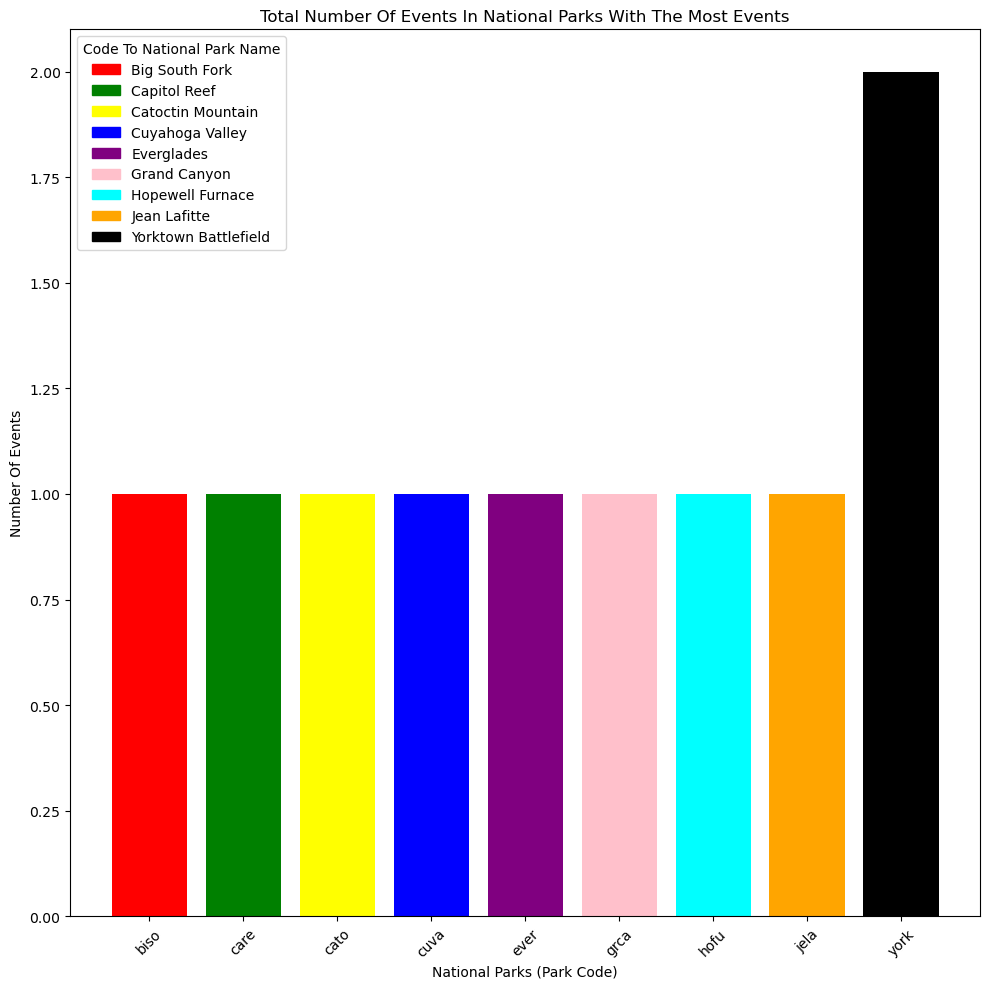

In [33]:
# Setting variables
total_events_by_park = events_df.groupby("Park Code")['Event'].count()
#print(total_event_by_park)

#getting the labels for the legend
most_events_labels = []
for name in range(0, total_events_by_park.size):
    try:
        most_events_labels.append(code_to_name['Full Name'][total_events_by_park.index[name]])
    except:
        most_events_labels.append("Park Name Not in Dict")
colors=['red', 'green', 'yellow', 'blue', 'purple', 'pink', 'cyan', 'orange', 'black']

# Creating bar graph
plt.figure(figsize=(10, 10))
plt.bar(total_events_by_park.index, total_events_by_park.values, color=colors)
plt.xticks(rotation = 45)

#get handles for legend
handles = [plt.Rectangle((0,0),1,1, color=colors[name]) for name in range(0, total_events_by_park.size)]


# Setting title and labels for bar graph
plt.title("Total Number Of Events In National Parks With The Most Events")
plt.legend(handles, most_events_labels, title="Code To National Park Name")
plt.xlabel("National Parks (Park Code)")
plt.ylabel("Number Of Events")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-7.png")
plt.tight_layout()
plt.show()

### Graph 10 - Visualizing The Data Frame For The Types Of Events In National Parks

Cultural/Craft Demonstration    2
Talk                            2
Other                           1
Guided Tour/Talk                1
Guided Tour/Talk/Walk           1
Exhibition/Show                 1
Volunteer Event                 1
Walk                            1
Name: Type, dtype: int64


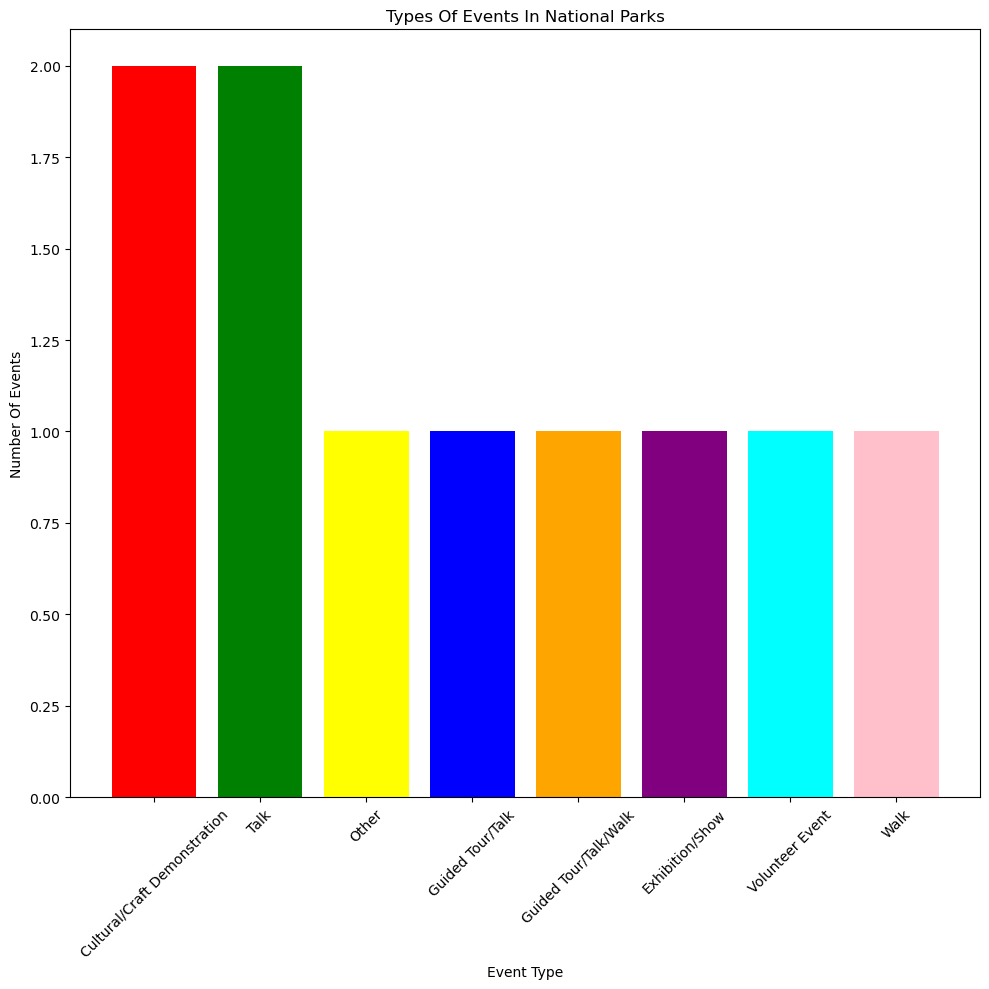

In [34]:
# Setting variables
events_type_count = events_df['Type'].value_counts()
print(events_type_count)

colors=['red', 'green', 'yellow', 'blue', 'orange', 'purple', 'cyan', 'pink', 'cornflowerblue']

# Creating bar graph
plt.figure(figsize=(10, 10))
plt.bar(events_type_count.index, events_type_count.values, color=colors)
plt.xticks(rotation = 45)

# Setting title and labels for bar graph
plt.title("Types Of Events In National Parks")
plt.xlabel("Event Type")
plt.ylabel("Number Of Events")

# Display and save bar graph
plt.savefig("output_data/Images/bargraph-8.png")
plt.tight_layout()
plt.show()

In [35]:
print(f"There are {total_events_by_park.size} parks with at least 2 Events.")
print(f"{code_to_name['Full Name'][total_events_by_park.idxmax()]} National Park has the most ({total_events_by_park.max()}) Events.")

There are 9 parks with at least 2 Events.
Yorktown Battlefield National Park has the most (2) Events.


### Summary Statistics 4 - Events and National Parks

In [36]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM For For Events and National Parks
df_mean = total_events_by_park.values.mean(axis=0)
df_median = total_events_by_park.median(axis=0)
df_variance = total_events_by_park.values.var(axis=0)
df_stdv = total_events_by_park.values.std(axis=0)
df_sem = total_events_by_park.sem(axis=0)

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.
df_summary_activities = pd.DataFrame({"Mean Events": df_mean,
                                    "Median Events": df_median,
                                    "Events Variance": df_variance,
                                    "Events Std. Dev.": df_stdv,
                                    "Events Std. Err.": df_sem},
                                    index=[0])
df_summary_activities

,Mean Events,Median Events,Events Variance,Events Std. Dev.,Events Std. Err.
0,1.111111,1.0,0.098765,0.31427,0.111111


### Analysis and Conclusions 4 - Explanation Of Visualization For The National Parks With The Most Events

- Graph 9 shows us the total number of events for national parks with the most events. This information could be useful to traverlers who want to go to a park with the most number of events to see/take part in. For example, in this case the Yorktown Battlefield National Park has the most events at a total of 2 events.

- Graph 10 shows us the amount of different types of events in national parks. This information can be useful in letting travelers know what types of events they can expect in the very few parks that offer events. The most common events in national parks which was talks as well as walks/guided tours.